# Example: Grid World Policy Iteration

In [1]:
# The autoreload extension will automatically load in new code as you edit files, 
# so you don't need to restart the kernel every time
%load_ext autoreload
%autoreload 2
from typing import Tuple, List
import numpy as np
from scipy.special import softmax
from ipywidgets import interact

from grid_world import GridWorld

In this example we will be using a `GridWorld` environment where there are a set of absorbing states that get a reward of 0 and for every other state visited gets a reward of -1. The actions are to go up, down, left, or right, respecting the boundaries of the grid. We can visualize the grid below.

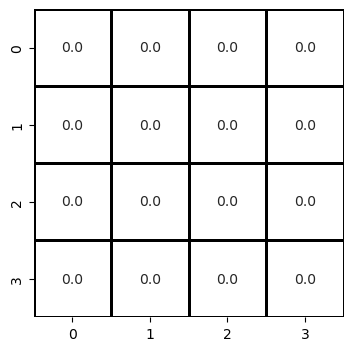

In [2]:
env = GridWorld(4, absorbing_states={(0,0), (3,3)})
env.render();

#### Step 1: Implement Policy Evaluation
First, we implement the function `compute_action_value` to compute the action-value (i.e. Q-value) for a given state and action using a one-step lookahead with the environment's value function. 
Then, we implement `bellman_expectation` which will compute the one-step Bellman update of the value function for a given state and stochastic policy. 
Finally, we implement the function `policy_evaluation` to implement the policy evaluation algorithm using the `bellman_expectation` function.

In [3]:
def compute_action_value(env: GridWorld, state: Tuple[int, int], action: Tuple[int, int], discount: float):
    """
    Compute the action value Q(x, u) for current state and action using one-step lookahead with the
    environment's value function.

    Args:
        env: grid world environment
        state: the (x, y) indices that define the location in the grid
        action: the movement direction (i.e. (1, 0)) action
        discount: discount factor
    """
    next_state, reward = env.step(state, action)
    return reward + discount * env.state_value[next_state]

def bellman_expectation(env: GridWorld, state: Tuple[int, int], policy_probs: List[float], discount: float) -> float:
    """
    Performs a one-step lookahead and applies the Bellman expectation equation to update the value for
    the given state.
    
    Args:
        env: grid world environment
        state: the (x, y) indices that define the location in the grid
        policy_probs: transition probabilities for each action for the given state
        discount: discount factor
    Returns:
        the new value for the specified state
    """
    value = 0
    for action_idx, action in env.actions.items():
        value += policy_probs[action_idx] * compute_action_value(env, state, action, discount)
    return value

def policy_evaluation(env: GridWorld, policy: np.ndarray, eps: float= 1e-2, max_steps: int=1, discount: float=1., in_place: bool=False):
    """
    Args:
        env: grid world environment
        policy: a numpy 3-D numpy array, where the first two dimensions identify a state and 
                the third dimension identifies the actions. The array stores the probability 
                of taking each action. I.e. policy[i, j, k] is the probability of selection action
                k from state (i,j).
        eps: convergence threshold
        max_steps: max number of iterations of the algorithm
        discount: discount factor
        in_place: if False, the value table is updated after all the new values have been calculated.
             if True the state [i, j] will new already new values for the states [< i, < j]
    """
    state_value_history = [env.state_value]
    converged = False
    for k in range(max_steps):
        values_prev = np.copy(env.state_value)
        # cache old values if not in place
        values = env.state_value if in_place else np.empty_like(
            env.state_value)

        # Update the `values` for each state
        for i in range(len(env.state_value)):
            for j in range(len(env.state_value[i])):
                # apply bellman expectation equation to each state
                state = (i, j)
                value = bellman_expectation(env, state, policy[i, j], discount)
                values[i, j] = value * discount

        # set the new value table
        env.state_value = values
        state_value_history.append(env.state_value)
        if (np.linalg.norm(values_prev - values, ord=np.inf) < eps):
            converged = True
            break
    return converged, state_value_history

Now, run the code below to run the policy evaluation algorithm on a simple grid world using a default random policy. Try playing around with a different discount factor to see how that effects the solution.

In [4]:
# Create GridWorld
env = GridWorld(4, absorbing_states={(0,0), (3,3)})

# Define random policy
policy = np.ones((*env.state_value.shape, len(env.actions))) * 0.25

# Run policy evaluation
num_steps = 10
discount = 1.0
converged, state_value_history = policy_evaluation(env, policy, max_steps=num_steps, discount=discount, in_place=False)
print(f"Converged: {converged}")
@interact(i=(0, num_steps))
def f(i=0):
    env.render(state_value_history[i]);

Converged: False


interactive(children=(IntSlider(value=0, description='i', max=10), Output()), _dom_classes=('widget-interact',…

Try playing around with an even larger example world below. Note that when rendering the environment with the given policy the red arrows indicate the actions, and their relative size indiciates the stochastic policy's probability for selecting that action.

Converged: True


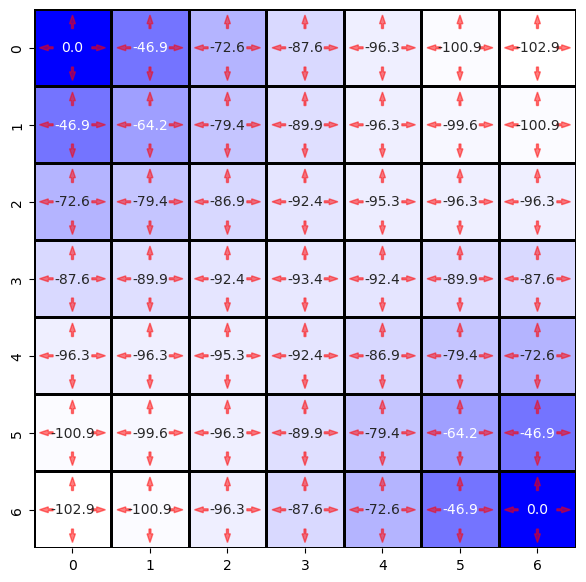

In [5]:
large_env = GridWorld(7, absorbing_states={(0,0), (6,6)})
policy = np.ones((*large_env.state_value.shape, len(env.actions))) * 0.25
converged, _ = policy_evaluation(large_env, policy, max_steps=1000, discount=1., in_place=False)
print(f"Converged: {converged}")
large_env.render(policy=policy);

#### Step 2: Implement Policy Iteration
Now we implement the `policy_iteration` algorithm below, leveraging the `policy_evaluation` function implemented above.

In [6]:
def policy_iteration(env: GridWorld, eps: float= 1e-2, max_steps: int=1, discount: float=1., β: float=1., in_place: bool=False):
    """
    Args:
        env: grid world environment
        eps: convergence threshold
        max_steps: max number of iterations of the algorithm
        discount: discount factor
        β: Boltzmann constant for softmax for stochastic policy definition from action values
        in_place: if False, the value table is updated after all the new values have been calculated.
             if True the state [i, j] will new already new values for the states [< i, < j]

    Returns:
        policy: a numpy 3-D numpy array, where the first two dimensions identify a state and 
                the third dimension identifies the actions. The array stores the probability 
                of taking each action. I.e. policy[i, j, k] is the probability of selection action
                k from state (i,j).
    """
    converged = False
    # Reset environment state value function and initialize policy with uniform distribution
    env.reset()
    policy = np.ones((*env.state_value.shape, len(env.actions))) * 0.25
    for k in range(max_steps):
        policy_prev = np.copy(policy)

        # Update state value function, env.state_value
        policy_evaluation(env, policy, max_steps=max_steps, discount=discount, in_place=in_place)

        # Improve policy
        for i in range(len(env.state_value)):
            for j in range(len(env.state_value[i])):
                # apply bellman expectation equation to each state
                state = (i, j)
                action_values = [compute_action_value(env, state, action, discount) for _, action in env.actions.items()]
                policy[i, j, :] = softmax(β * np.array(action_values))
        
        if (np.linalg.norm((policy - policy_prev).flatten(), ord=np.inf) < eps):
            converged = True
            break   
    return converged, policy

Now, we will revisit the large grid world and see how the optimal value function is different from the value function for the random policy evaluated above.

Converged: True


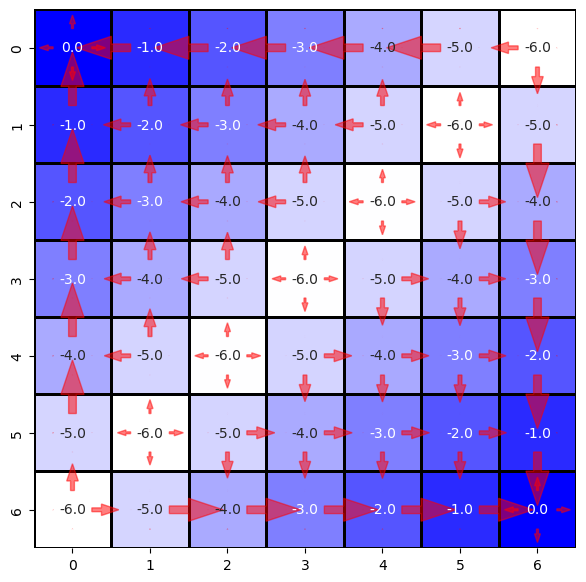

In [7]:
large_env = GridWorld(7, absorbing_states={(0,0), (6,6)})
converged, policy = policy_iteration(large_env, max_steps=1000, discount=1., β=5.)
print(f"Converged: {converged}")
large_env.render(policy=policy);